In [155]:
import chess
import chess.pgn
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from collections import defaultdict
from itertools import groupby

In [136]:
training = open('training-boards.txt').read().split('\n\n')
training = [x.strip().split('\n', 3) for x in training]
training = [(board, float(score), int(idx), label) for score, idx, label, board in training]
training[0]

KeyboardInterrupt: 

In [ ]:
CHARS = {
    '.': 0,
    'B': 1,
    'K': 2,
    'N': 3,
    'P': 4,
    'Q': 5,
    'R': 6,
    'b': 7,
    'k': 8,
    'n': 9,
    'p': 10,
    'q': 11,
    'r': 12,
}


def one_hot(ch):
    res = np.zeros(len(CHARS))
    res[CHARS[ch]] = 1
    return res


def encode_board(board):
    board = board.replace(' ', '').replace('\n', '')
    return np.asarray([one_hot(ch) for ch in board])


def encode_board_2d(board):
    board = board.replace(' ', '').split('\n')
    return np.asarray([[one_hot(ch) for ch in line] for line in board])

In [ ]:
boards = np.asarray([encode_board_2d(board) for board, score, idx, label in training])
boards[0].shape

In [ ]:
by_idx = defaultdict(list)
for t_idx, (board, score, idx, label) in enumerate(training):
    by_idx[idx].append((label, t_idx))
by_idx[0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    boards, np.asarray([score for board, score, idx, label in training]), test_size=0.25
)
X_train.shape

In [ ]:
def build_model_1d():
    board_input = keras.Input(shape=(8, 8, 13))
    board_flat = layers.Flatten()(board_input)
    dense_1 = layers.Dense(512, activation="relu")(board_flat)
    dense_2 = layers.Dense(64, activation="relu")(dense_1)
    score = layers.Dense(1, activation='sigmoid')(dense_2)
    model = keras.Model(inputs=board_input, outputs=score, name='neuralchess')
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.RMSprop(),
    )
    return model

model = build_model_1d()
model.summary()

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=5, validation_split=0.1)

test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

In [ ]:
predicted_scores = model.predict(boards)
predicted_scores.shape, predicted_scores[0]

In [ ]:
def adjust_predicted_scores(predicted_scores):

    adjusted_scores = np.zeros(predicted_scores.shape)

    right = 0
    for lst in by_idx.values():
        scores = [predicted_scores[t_idx] for label, t_idx in lst]
        played, *others = scores
        m = max(max(others) * 1.2, played)
        if played > max(others):
            right += 1
        d = (1 - (m - played) / sum(others))
        idx_scores = [m, *(d * s for s in others)]
        for score, (label, t_idx) in zip(idx_scores, lst):
            adjusted_scores[t_idx] = score
            
    return right, adjusted_scores

right, adjusted_scores = adjust_predicted_scores(predicted_scores)
        
print(100 * right / len(by_idx))

In [ ]:
for t, n, a in zip(training, new_scores, adjusted_scores[:20]):
    print(t[1], n, a)

In [ ]:
for mm in range(10):
    predicted_scores = model.predict(boards)
    right, adjusted_scores = adjust_predicted_scores(predicted_scores)
    loss = model.evaluate(X_test, y_test, verbose=2)
        
    print('right:', 100 * right / len(by_idx), 'loss:', loss)

    X_train, X_test, y_train, y_test = train_test_split(
        boards, adjusted_scores, test_size=0.25
    )

    model.fit(X_train, y_train, batch_size=256, epochs=2, validation_split=0.1)

In [251]:
model = keras.models.load_model('neuralchess-game-d3.model')

In [ ]:
board = chess.Board()

def eval_board(board):
    board = str(board)
    encoded = encode_board_2d(board)
    return model.predict(encoded.reshape(1, 8, 8, 13))[0][0]

eval_board(board)

In [235]:
def recurse_board(board, depth):
    res = []
    for m in [*board.legal_moves]:
        board.push(m)
        if depth > 0:
            for b in recurse_board(board, depth - 1):
                res.append([m] + b)
        else:
            res.append([m, encode_board_2d(str(board))])
        board.pop()
    return res


def reduce_boards(boards, do_min):
    fn = (lambda b:-b[0]) if do_min else (lambda b:b[0])
    if len(boards[0]) == 3:
        return max(boards, key=fn)
    reduced = [max(gb_boards, key=fn)[:-1] for k, gb_boards in groupby(boards, lambda board:board[2:-1])]
    return reduce_boards(reduced, not do_min)


def best_move_3(board, verbose=False, depth=1):
    import time
    t = time.time()
    moves = recurse_board(board, depth)
    scores = model.predict(np.asarray([m[-1] for m in moves]))
    boards = [[score[0], idx, *board[:-1]] for idx, (score, board) in enumerate(zip(scores, moves))]
#    return boards
    r1 = reduce_boards(boards, depth % 2 == 1)
    if verbose:
        print(r1)
        print(time.time() - t)
        print(moves[r1[1]])
    return r1[2], r1[0]



f = best_move_3(board, verbose=True)
f
#[*board.legal_moves]

[0.4826581, 24, Move.from_uci('g1f3')]
0.15581727027893066
[Move.from_uci('g1f3'), Move.from_uci('h7h6'), array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0.,

(Move.from_uci('g1f3'), 0.4826581)

In [222]:
ff = [b for b in f if b[2] == chess.Move.from_uci('c4f7') or b[2] == chess.Move.from_uci('g1h3')]
ff2 = [max(gb_boards) for k, gb_boards in groupby(ff, lambda board:board[-2])]
ff3 = [min(gb_boards) for k, gb_boards in groupby(ff2, lambda board:board[-3])]
ff3

[[0.55120945,
  14,
  Move.from_uci('c4f7'),
  Move.from_uci('e8f7'),
  Move.from_uci('d2d3')],
 [0.36533195,
  7162,
  Move.from_uci('g1h3'),
  Move.from_uci('d7d5'),
  Move.from_uci('e4d5')]]

In [206]:
f2 = [max(gb_boards)[:-1] for k, gb_boards in groupby(f, lambda board:board[-2])]
f2

[[0.55120945, 14, Move.from_uci('c4f7'), Move.from_uci('e8f7')],
 [0.5590793, 47, Move.from_uci('c4f7'), Move.from_uci('e8e7')],
 [0.47433993, 63, Move.from_uci('c4e6'), Move.from_uci('h8g8')],
 [0.40396556, 92, Move.from_uci('c4e6'), Move.from_uci('f8e7')],
 [0.4396359, 125, Move.from_uci('c4e6'), Move.from_uci('f8d6')],
 [0.38910908, 162, Move.from_uci('c4e6'), Move.from_uci('f8c5')],
 [0.43839476, 191, Move.from_uci('c4e6'), Move.from_uci('f8b4')],
 [0.41780227, 225, Move.from_uci('c4e6'), Move.from_uci('f8a3')],
 [0.53461593, 253, Move.from_uci('c4e6'), Move.from_uci('e8e7')],
 [0.47140932, 286, Move.from_uci('c4e6'), Move.from_uci('d8e7')],
 [0.45492283, 340, Move.from_uci('c4e6'), Move.from_uci('b8c6')],
 [0.4595272, 356, Move.from_uci('c4e6'), Move.from_uci('b8a6')],
 [0.7274846, 385, Move.from_uci('c4e6'), Move.from_uci('f6g8')],
 [0.45590013, 418, Move.from_uci('c4e6'), Move.from_uci('f6h5')],
 [0.5984559, 453, Move.from_uci('c4e6'), Move.from_uci('f6d5')],
 [0.59079874, 486, 

In [22]:
def best_move_2(board, verbose=False):
    max_val = 0
    max_move = None
    for m in board.legal_moves:
        board.push(m)
        min_val = 1.0
        min_move = None
        for m2 in board.legal_moves:
            board.push(m2)
            score = eval_board(board)
            if score < min_val:
                min_val = score
                min_move = m2
            board.pop()
        if min_val > max_val:
            max_val = min_val
            max_move = m
        if verbose:
            print(m, score)
        board.pop()
    return max_move, max_val



def best_move(board, verbose=False):
    max_val = 0
    max_move = None
    for m in board.legal_moves:
        board.push(m)
        score = eval_board(board)
        if verbose:
            print(m, score)
        if score > max_val:
            max_val = score
            max_move = m
        board.pop()
    return max_move, max_val

move, score = best_move(board)
move, score

(Move.from_uci('c2c4'), 0.49417305)

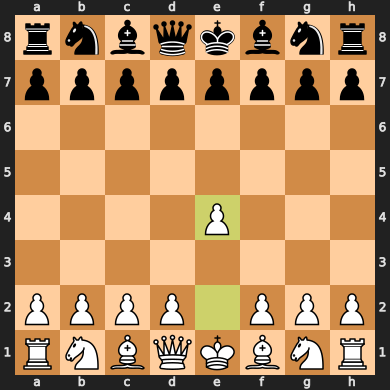

In [252]:
board = chess.Board()
move, score = best_move_3(board)
board.push(move)
board

> e2e7


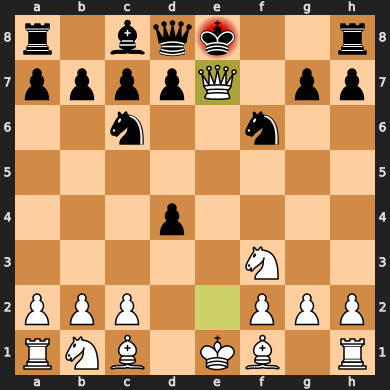

In [259]:
board.push_san("f8e7")
move, score = best_move_3(board, verbose=False)
print('>', move)
board.push(move)
board

0.4865107


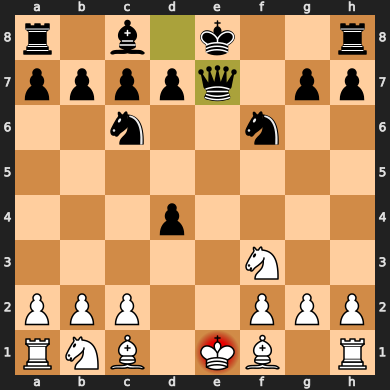

In [262]:
board.push(chess.Move.from_uci('d8e7'))
print(eval_board(board))
board

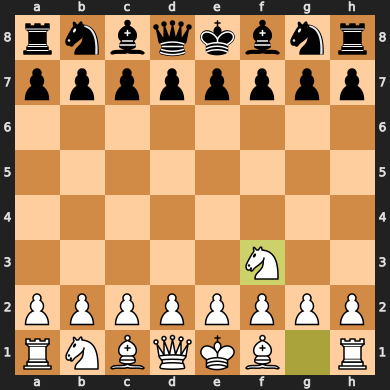

In [249]:
board2 = chess.Board()
move, score = best_move_2(board2)
board2.push(move)
board2

> c2c4


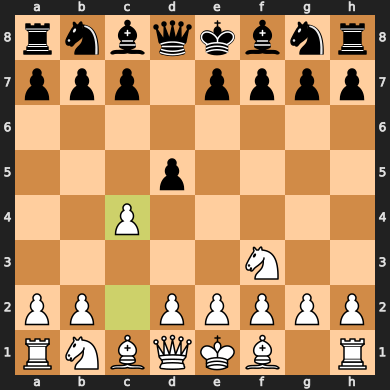

In [250]:
board2.push_san("d7d5")
move, score = best_move_2(board2, verbose=False)
print('>', move)
board2.push(move)
board2